# Grover's Algorithm

In this section, we introduce Grover's algorithm and how it can be used to solve unstructured search problems. We then implement the quantum algorithm using Qiskit, and run on a simulator and device.


## 1. Introduction <a id='introduction'></a>



### Creating an Oracle

For the examples in this textbook, our 'database' is comprised of all the possible computational basis states our qubits can be in. For example, if we have 3 qubits, our list is the states $|000\rangle, |001\rangle, \dots |111\rangle$ (i.e the states $|0\rangle \rightarrow |7\rangle$).

Grover’s algorithm solves oracles that add a negative phase to the solution states. I.e. for any state $|x\rangle$ in the computational basis:

$$
U_\omega|x\rangle = \bigg\{
\begin{aligned}
\phantom{-}|x\rangle \quad \text{if} \; x \neq \omega \\
-|x\rangle \quad \text{if} \; x = \omega \\
\end{aligned}
$$

This oracle will be a diagonal matrix, where the entry that correspond to the marked item will have a negative phase. For example, if we have three qubits and $\omega = \text{101}$, our oracle will have the matrix:

$$
U_\omega = 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{aligned}
\\
\\
\\
\\
\\
\\
\leftarrow \omega = \text{101}\\
\\
\\
\\
\end{aligned}
$$


What makes Grover’s algorithm so powerful is how easy it is to convert a problem to an oracle of this form.  For these problems, we can create a function $f$ that takes a proposed solution $x$, and returns $f(x) = 0$ if $x$ is not a solution ($x \neq \omega$) and $f(x) = 1$ for a valid solution ($x = \omega$). Our oracle can then be described as:

$$
U_\omega|x\rangle = (-1)^{f(x)}|x\rangle
$$

and the oracle's matrix will be a diagonal matrix of the form:

$$
U_\omega = 
\begin{bmatrix}
(-1)^{f(0)} &   0         & \cdots &   0         \\
0           & (-1)^{f(1)} & \cdots &   0         \\
\vdots      &   0         & \ddots & \vdots      \\
0           &   0         & \cdots & (-1)^{f(2^n-1)} \\
\end{bmatrix}
$$


## 2. Example: 2 Qubits <a id='2qubits'></a>

Let's first have a look at the case of Grover's algorithm for $N=4$ which is realized with 2 qubits.
<ol>


We will now follow through an example using a specific oracle.

#### Oracle for $\lvert \omega \rangle = \lvert 11 \rangle$
Let's look at the case $\lvert w \rangle = \lvert 11 \rangle$. The oracle $U_\omega$ in this case acts as follows: 

$$U_\omega | s \rangle = U_\omega \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle + |11\rangle \right) = \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle - |11\rangle \right).$$

or:

$$
U_\omega = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1 \\
\end{bmatrix}
$$

which you may recognise as the controlled-Z gate. Thus, for this example, our oracle is simply the controlled-Z gate:

![image6](images/grover_circuit_2qbuits_oracle_11.svg)

#### Reflection $U_s$
In order to complete the circuit we need to implement the additional reflection $U_s = 2|s\rangle\langle s| - \mathbb{1}$. Since this is a reflection about $|s\rangle$, we want to add a negative phase to every state orthogonal to $|s\rangle$. 

One way we can do this is to use the operation that transforms the state $|s\rangle \rightarrow |0\rangle$, which we already know is the Hadamard gate applied to each qubit:

$$H^{\otimes n}|s\rangle = |0\rangle$$

Then we apply a circuit that adds a negative phase to the states orthogonal to $|0\rangle$:

$$U_0 \frac{1}{2}\left( \lvert 00 \rangle + \lvert 01 \rangle + \lvert 10 \rangle + \lvert 11 \rangle \right) = \frac{1}{2}\left( \lvert 00 \rangle - \lvert 01 \rangle - \lvert 10 \rangle - \lvert 11 \rangle \right)$$

i.e. the signs of each state are flipped except for $\lvert 00 \rangle$. As can easily be verified, one way of implementing $U_0$ is the following circuit (what we called S in the slides):

![Circuit for reflection around |0>](images/grover_circuit_2qbuits_reflection_0.svg)

Finally, we do the operation that transforms the state $|0\rangle \rightarrow |s\rangle$ (the H-gate again):

$$H^{\otimes n}U_0 H^{\otimes n} = U_s$$

The complete circuit for $U_s$ looks like this:

![Circuit for reflection around |s>](images/grover_circuit_2qbuits_reflection.svg)


#### Full Circuit for $\lvert w \rangle = |11\rangle$
Since in the particular case of $N=4$ only one rotation is required we can combine the above components to build the full circuit for Grover's algorithm for the case $\lvert w \rangle = |11\rangle$:

![image10](images/grover_circuit_2qubits_full_11.svg)

### 2.1 Qiskit Implementation

We now implement Grover's algorithm for the above case of 2 qubits for $\lvert w \rangle = |11\rangle$.

In [20]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

We start by preparing a quantum circuit with two qubits:

In [21]:
n = 2
grover_circuit = QuantumCircuit(n)

Then we simply need to write out the commands for the circuit depicted above. First, we need to initialize the state $|s\rangle$. Let's create a general function (for any number of qubits) so we can use it again later:

In [22]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    qc.barrier()
    return qc

In [23]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()

┌───┐ ░ 
q_0: ┤ H ├─░─
     ├───┤ ░ 
q_1: ┤ H ├─░─
     └───┘ ░

Apply the Oracle for $|w\rangle = |11\rangle$. This oracle is specific to 2 qubits:

In [24]:
grover_circuit.cz(0,1) # Oracle
grover_circuit.barrier()
grover_circuit.draw()

┌───┐ ░     ░ 
q_0: ┤ H ├─░──■──░─
     ├───┤ ░  │  ░ 
q_1: ┤ H ├─░──■──░─
     └───┘ ░     ░

<span id="general_diffuser"></span>We now want to apply the diffuser ($U_s$). As with the circuit that initializes $|s\rangle$, we'll create a general diffuser (for any number of qubits) so we can use it later in other problems. 

In [25]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])

grover_circuit.draw()

┌───┐ ░     ░ ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├─░──■──░─┤ H ├┤ Z ├─■─┤ H ├
     ├───┤ ░  │  ░ ├───┤├───┤ │ ├───┤
q_1: ┤ H ├─░──■──░─┤ H ├┤ Z ├─■─┤ H ├
     └───┘ ░     ░ └───┘└───┘   └───┘

This is our finished circuit.

### 2.1.1 Experiment with Simulators <a id='2qubits-simulation'></a>

Let's run the circuit in simulation. First, we can verify that we have the correct statevector:

In [26]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(grover_circuit)
grover_circuit.draw()


┌───┐ ░     ░ ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├─░──■──░─┤ H ├┤ Z ├─■─┤ H ├
     ├───┤ ░  │  ░ ├───┤├───┤ │ ├───┤
q_1: ┤ H ├─░──■──░─┤ H ├┤ Z ├─■─┤ H ├
     └───┘ ░     ░ └───┘└───┘   └───┘

In [27]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(grover_circuit)
grover_circuit.draw()
result = sv_sim.run(qobj).result()
statevec = result.get_statevector()

#from qiskit_textbook.tools import vector2latex
#vector2latex(statevec, pretext="|\\psi\\rangle =")

As expected, the amplitude of every state that is not $|11\rangle$ is 0, this means we have a 100% chance of measuring $|11\rangle$:

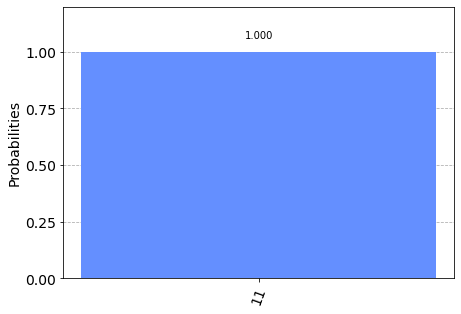

In [28]:
grover_circuit.measure_all()

qasm_sim = Aer.get_backend('qasm_simulator')
qobj = assemble(grover_circuit)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

##  References <a id='references'></a>

1. L. K. Grover (1996), "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (STOC 1996), [doi:10.1145/237814.237866](http://doi.acm.org/10.1145/237814.237866), [arXiv:quant-ph/9605043](https://arxiv.org/abs/quant-ph/9605043)
2. C. Figgatt, D. Maslov, K. A. Landsman, N. M. Linke, S. Debnath & C. Monroe (2017), "Complete 3-Qubit Grover search on a programmable quantum computer", Nature Communications, Vol 8, Art 1918, [doi:10.1038/s41467-017-01904-7](https://doi.org/10.1038/s41467-017-01904-7), [arXiv:1703.10535 ](https://arxiv.org/abs/1703.10535)
3. I. Chuang & M. Nielsen, "Quantum Computation and Quantum Information", Cambridge: Cambridge University Press, 2000.

In [10]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.19.1', 'qiskit-aer': '0.10.2', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.18.3', 'qiskit-aqua': None, 'qiskit': '0.34.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}